# Imports

In [1]:
import sys
modules: set = set(sys.modules)
if not ('jupyternotify') in modules:
    %pip install -q jupyternotify
import numpy as np
if np.__version__ < "1.2.4":
    %pip install -q numpy==1.2.4
if not ('folium' in modules):
    %pip install -q folium==0.2.1
    modules.add('folium')
if not ('imgaug' in modules):
    %pip install -q imgaug==0.2.6
    modules.add('imgaug')
if not ('tensorflow_text' in modules):
    %pip install -q tensorflow_text==2.9.0
    modules.add('tensorflow_text')
if not ('seaborn' in modules):
    %pip -q install -q seaborn
    modules.add('seaborn')
if not ('tqdm' in modules):
    %pip install -q tqdm
    modules.add('tqdm')
if not ('matplotlib' in modules):
    %pip install -q matplotlib
    modules.add('matplotlib')

In [22]:
# standart liberies

from typing import List, Tuple
import datetime
import os
import csv
import random
import functools
import statistics
import asyncio
from concurrent.futures import ThreadPoolExecutor
import timeit

try:
    import tensorflow as tf
    import tensorflow_text as tf_text
    import pandas as pd
    import seaborn as sns
    import numpy as np
    import tqdm
    import matplotlib.pyplot as plt
    %load_ext jupyternotify
    
except ImportError:
    if np.__version__ < "1.2.4":
        %pip install -q numpy==1.2.4
    if not ('folium' in modules):
        %pip install -q folium==0.2.1
        modules.add('folium')
    if not ('imgaug' in modules):
        %pip install -q imgaug==0.2.6
        modules.add('imgaug')
    if not ('tensorflow_text' in modules):
        %pip install -q tensorflow_text==2.9.0
        modules.add('tensorflow_text')
        import tensorflow_text as tf_text
    if not ('seaborn' in modules):
        %pip -q install -q seaborn
        import seaborn as sns
        modules.add('seaborn')
    if not ('tqdm' in modules):
        %pip install -q tqdm
        import tqdm
    exit()

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [3]:
print(f"Python version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")
print(f"tf text version: {tf_text.__version__}")

Python version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Tensorflow version: 2.9.1
tf text version: 2.9.0


In [4]:
print('GPU info:/n')
!nvidia-smi

GPU info:/n
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
tf.random.set_seed(0)
random.seed(0)
tf.keras.backend.set_floatx('float16')

In [6]:
device: str
if 'google' in modules:
    device = 'colab'
else:
    device = 'locally'
curr_folder = os.getcwd()

# Hyper-Parameters

In [7]:
set_size: int = 32
num_layers: int = 4
d_model: int = 128
dff: int = 256
num_heads: int = 8
learning_rate: float = 0.001
max_seq_len: int = 1024
dropout_rate: float = 0.1
batch_size: int = 16

# Data loading

In [8]:
if device == 'colab':  # If notebook is ran on colab
    from google.colab import drive
    drive.mount('/drive')
    df: pd.DataFrame = pd.read_csv('/drive/MyDrive/final_project/wikipedia_articles.csv')
else:  # If notebook is ran on my laptop
    df: pd.DataFrame = pd.read_csv('wiki_data/articles.csv')
print(df.shape)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
(30279, 2)


In [9]:
df: pd.Series = df['text']
data_list: List[str] = df.to_list()
DATA_SIZE = len(data_list)
print(f"There are {DATA_SIZE} data points")
string_lengths: List[int] = [len(data_point) for data_point in data_list]
max_string_len = max(string_lengths)
print(f"The length of the longest text IN CHARACTERS is: {max_string_len}")
min_string_len = min(string_lengths)
print(f"The length of the shortest text IN CHARACTERS is: {min_string_len}")

There are 30279 data points
The length of the longest text IN CHARACTERS is: 141803
The length of the shortest text IN CHARACTERS is: 816


# Tokenizing

## Creating the vocabulary

In [10]:
# tensor_list: List = [tf.convert_to_tensor(data_point) for data_point in data_list]
# print(type(tensor_list[0]))

In [11]:
# %%time
bert_tokenizer_params: dict = dict(lower_case=True)
# reserved_tokens: List[str] = ["[PAD]", "[UNK]", "[START]", "[END]", "[MASK]"]
VOCAB_SIZE: int = 8192  # Always the same for all models
#
# bert_vocab_args: dict = dict(
#     # The target vocabulary size
#     vocab_size = VOCAB_SIZE,
#     # Reserved tokens that must be included in the vocabulary
#     reserved_tokens=reserved_tokens,
#     # Arguments for `tf_text.BertTokenizer`
#     bert_tokenizer_params=bert_tokenizer_params,
#     # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
#     learn_params={},
# )
# data_set: tf.data.Dataset = tf.data.Dataset.from_tensor_slices(tensor_list)
# #I already ran this code and saved the file to C:/yoni/final_project/model/look_up_table.txt
# vocab: List[str] = bert_vocab_from_dataset.bert_vocab_from_dataset(
#     data_set,
#     **bert_vocab_args,)

In [12]:
# len(vocab), vocab[:10]

In [13]:
# with open('C:/yoni/final_project/model/look_up_table.txt', 'w') as f:
#     for token in vocab:
#         f.write(token + ' ')
if device == 'colab':  # If notebook is ran on colab
    path = '/drive/MyDrive/final_project/look_up_table.txt'
else:  # If notebook is ran on my laptop
    device = 'local'
    path = 'C:/yoni/final_project/model/look_up_table.txt'
with open(path, 'r') as f:
    vocab: List[str] = f.read().split()

In [14]:
print(f"the type of the items in vocab: {type(vocab[0])}")
print(f"the first 15 items in vocab: {vocab[:15]}")
print(f" the length of vocab: {len(vocab)}")

the type of the items in vocab: <class 'str'>
the first 15 items in vocab: ['[PAD]', '[UNK]', '[START]', '[END]', '[MASK]', "'", ',', '.', '0', '1', '2', '3', '4', '5', '6']
 the length of vocab: 7882


In [15]:
tensor_vocab: List[tf.Tensor] = [tf.convert_to_tensor(token_key, dtype=tf.string) for token_key in vocab]  # dtype = tf.String
print(f" the type of the items in tensor_vocab is: {type(tensor_vocab[0])}")
print(f" the data type of the tensors in tensor_vocab is: {tensor_vocab[0].dtype}")

 the type of the items in tensor_vocab is: <class 'tensorflow.python.framework.ops.EagerTensor'>
 the data type of the tensors in tensor_vocab is: <dtype: 'string'>


In [16]:
lookup_table = tf.lookup.StaticVocabularyTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=tensor_vocab,
        key_dtype=tf.string,
        values=tf.range(tf.size(vocab, out_type=tf.int64), dtype=tf.int64),
        value_dtype=tf.int64),
    num_oov_buckets=1
)
tokenizer = tf_text.BertTokenizer(lookup_table, **bert_tokenizer_params)

## Creating the tokenizer

## Tokenizing the data

In [17]:
# reserved_tokens: List[str] = ["[PAD]", "[UNK]", "[START]", "[END]", "[MASK]"]
# START: int = tf.argmax(tf.constant(reserved_tokens) == "[START]")  # The value of the start token
# END: int = tf.argmax(tf.constant(reserved_tokens) == "[END]")  # The value of the end token
# starts = tf.cast(tf.Variable([START]), dtype = tf.int32)  # Tensor of shape [1] and dtype int
# ends = tf.cast(tf.Variable([END]), dtype = tf.int32)  # Tensor of shape [1] and dtype int
starts = tf.constant([2], dtype=tf.int32)
ends = tf.constant([3], dtype=tf.int32)

In [18]:
async def tokenize(text: str) -> tf.Tensor:
    """Converts string to tensor. takes about 0.02 seconds per call"""
    ragged: tf.RaggedTensor = tokenizer.tokenize(text)[0, :]
    eager: tf.Tensor = ragged.to_tensor(default_value=0, shape=[None, 1])  # 0 is the value of the padding token
    sqeezed: tf.Tensor = tf.squeeze(eager, axis=1)
    typed: tf.Tensor = tf.cast(sqeezed, tf.int32)
    edited: tf.Tensor = tf.concat([starts, typed, ends], axis=0)
    return edited

In [ ]:
# %time

# tokenized_data: List[tf.Tensor] = [tokenize(data_point) for data_point in tqdm.tqdm(data_list)] 
# tqdm is a progress bar

# replace with an asyncio implementation:

async def tokenize_list(a_data_list: List[str]) -> List[tf.Tensor]:
    return await asyncio.gather(*[tokenize(data_point) for data_point in a_data_list]) 

# copilot completion use tokenize_list:

tokenized_data: List[tf.Tensor] = asyncio.run(tokenize_list(data_list))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


RuntimeError: ignored

In [29]:
print(len(tokenized_data))
print(tokenized_data[0].shape)
print(tokenized_data[0][:10])

TypeError: ignored

25315
178


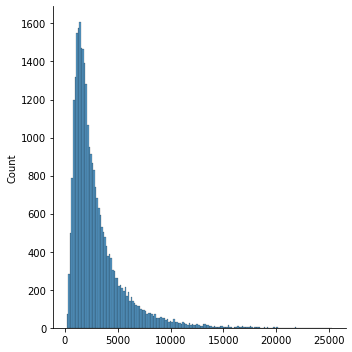

In [ ]:
lengths_tokenized: List[int] = [text.shape[0] for text in tokenized_data]
print(max(lengths_tokenized))
print(min(lengths_tokenized))
sns.displot(lengths_tokenized);

This is a plot of the distribution of the lengths of the tokenized data (AKA how many tokens in each data point of the data set).
We can see that there is very few data points with length over 8192 (2^13).
A model that can handle long texts is very expensive (both in emory and runtime).
Therefore I will filter out all texts longer than 8192 tokens.
Note that 8192 is also a lot compared to the capacity of similar sized transformers.

### Filter too long texts

In [ ]:
def chunk_tensor(tensor: tf.Tensor, max_len: int = max_seq_len) -> List[tf.Tensor]:
    """Splits 1d tensor to chunks (1d tensors) of maximum size: max_len"""
    return [tensor[x:x+max_seq_len] for x in range(0, tensor.shape[0], max_seq_len)]

In [ ]:
chunked_data: List[tf.Tensor] = []
for tensor in tokenized_data:
    chunks = chunk_tensor(tensor, max_seq_len)
    for chunk in chunks:
        chunked_data.append(chunk)
DATA_SIZE: int = len(chunked_data)
print(DATA_SIZE)
print(chunked_data[0].shape)

102768
(670,)


In [ ]:
def pad(tensor: tf.Tensor) -> tf.Tensor:
    """Pads the tensor to the length of the longest text in the data set"""
    padded: tf.Tensor = tf.pad(tensor=tensor, paddings=[[0, max_seq_len - tensor.shape[0]]], mode='CONSTANT', constant_values=0)
    # 0 is the padding token
    return padded

In [ ]:
padded_data: List[tf.Tensor] = [pad(text) for text in chunked_data]
print(padded_data[0])

tf.Tensor([   2 1011 7670 ...    0    0    0], shape=(1024,), dtype=int32)


## Train test val split

In [ ]:
random.shuffle(padded_data)
train_size: int = int(DATA_SIZE * 0.8)
val_test_size: int = int(DATA_SIZE * 0.1)  # Both validation and test get 10% of the data

train_tokenized: List[tf.Tensor] = padded_data[:train_size]
val_tokenized: List[tf.Tensor] = padded_data[train_size:(val_test_size + train_size)]
test_tokenized: List[tf.Tensor] = padded_data[(train_size + val_test_size):]

In [ ]:
def list_to_dataset(tokenized_list: List[tf.Tensor]) -> tf.data.Dataset:
    """Converts a list of tokenized texts after all preprocessing to a tf.data.Dataset"""
    dataset: tf.data.Dataset = tf.data.Dataset.from_tensor_slices(tokenized_list)
    batched: tf.data.Dataset = dataset.batch(batch_size)
    return batched

train_set: tf.data.Dataset = list_to_dataset(train_tokenized)
val_set: tf.data.Dataset = list_to_dataset(val_tokenized)
test_set: tf.data.Dataset = list_to_dataset(test_tokenized)

list_train_set = list(train_set)
list_val_set = list(val_set)
list_test_set = list(test_set)

del train_set, val_set, test_set

## Clear memory

In [ ]:
del train_tokenized, test_tokenized, val_tokenized
del padded_data, chunked_data, tokenized_data, data_list, df, lengths_tokenized, 
del string_lengths, lookup_table

# Model


## Positional encoding

The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

where $d_{model}$ is the model dimension, $pos$ is the position and $i$ is the index of the embedding.
this is taken from the paper: attention is all you need.

In [ ]:
def get_angles(pos: int, i: int, d_model: int) -> tf.Tensor:
    """Returns the angle in radians for a given position and timestamp"""
    if tf.keras.backend.floatx() == 'float32':
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    else:
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float16(d_model))

    return pos * angle_rates

In [ ]:
def positional_encoding(position: int, d_model: int) -> tf.Tensor:
    """Returns the positional encoding for a given position and timestamp"""
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encode = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encode, dtype=tf.keras.backend.floatx())

In [ ]:
# n, d = 2048, 512
# pos_encoding = positional_encoding(n, d)
# print(pos_encoding.shape)
# print(pos_encoding)

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

In [ ]:
def create_padding_mask(seq: tf.Tensor) -> tf.Tensor:
    seq = tf.cast(tf.math.equal(seq, 0), tf.keras.backend.floatx())

    # add extra dimensions to add the padding
    
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

Just to check if it works

In [ ]:
# x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
# create_padding_mask(x)

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third token, only the first and second token will be used. Similarly to predict the fourth token, only the first, second and the third tokens will be used and so on.

In [ ]:
def create_look_ahead_mask(size: int) -> tf.Tensor:
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    mask = tf.cast(mask, dtype=tf.keras.backend.floatx())
    return mask  # (seq_len, seq_len)

In [ ]:
# exm = tf.random.uniform((1, 3))
# print(exm)
# temp = create_look_ahead_mask(exm.shape[1])
# print(temp)

In [ ]:
def create_masks(inp: tf.Tensor, tar: tf.Tensor, set_size: int):
        # Encoder padding mask
        enc_padding_mask = create_padding_mask(inp)

        # Used in the 2nd attention block in the decoder.
        # This padding mask is used to mask the encoder outputs.
        dec_padding_mask = create_padding_mask(inp)

        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        look_ahead_mask = create_look_ahead_mask(set_size)
        dec_target_padding_mask = create_padding_mask(tar)
        look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        return enc_padding_mask, look_ahead_mask, dec_padding_mask

## Layers and blocks

In [ ]:
def scaled_dot_product_attention(q: tf.Tensor, k: tf.Tensor, v: tf.Tensor, mask: tf.Tensor) -> tf.Tensor:
    """Returns the attention weights.
    Args:
      q: query shape == (..., inp_len, depth)
      k: key shape == (..., inp_len, depth)
      v: value shape == (..., inp_len, depth_v)
      mask: Float tensor with shape broadcast-able
            to (..., inp_len, inp_len). Defaults to None.

    Returns:
      output, attention_weights
    """
    # print(f"mask: {mask[0]}")
    # print(f"q: {q[0]}")
    # print(f"k: {k[0]}")
    # print(f"v: {v[0]}")
    matmul_qk: tf.Tensor = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    # print(f"matmul_qk: {matmul_qk[0]}")

    # scale matmul_qk
    depth: tf.Tensor = tf.cast(tf.shape(k)[-1], tf.keras.backend.floatx())  # depth
    # print(f"depth: {depth}")
    
    scaled_attention_logits: tf.Tensor = matmul_qk / tf.math.sqrt(depth)
    # print(f"scaled_attention_logits: {scaled_attention_logits[0]}")

    # add the mask to the scaled tensor.
    if mask is not None:
        # noinspection PyTypeChecker
        if tf.keras.backend.floatx() == 'float16':
            scaled_attention_logits += (mask * tf.float16.min)  # changed from -1e9 to prevent nan's
        else:
            scaled_attention_logits += (mask * -1e9) 
        # print(f"scaled_attention_logits: {scaled_attention_logits[0]}")

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    # print(f"attention_weights: {attention_weights[0]}")

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    # print(f"output: {output[0]}")
    should_print = False
    return output

In [ ]:
class My_multi_head_attention(tf.keras.layers.Layer):
    # __slots__ = ["num_heads", "d_model", "depth", "wq", "wk", "wv", "dense"]
    """U can use the built-in tf.keras.layers.multihead_attention but is caused a bug for me"""
    def __init__(self, num_heads: int, d_model: int):
        super(My_multi_head_attention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x: tf.Tensor, batch_size) -> tf.Tensor:
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v_k: tf.Tensor, q: tf.Tensor, mask: tf.Tensor) -> tf.Tensor:
        batch_size = tf.shape(q)[0]
        # print(f"v_k: {v_k.numpy()}")

        q: tf.Tensor = self.wq(q)  # (batch_size, seq_len, d_model)
        # print(f"q1: {q.numpy()}")
        k: tf.Tensor = self.wk(v_k)  # (batch_size, seq_len, d_model)
        # print(f"k1: {k.numpy()}")
        v: tf.Tensor = self.wv(v_k)  # (batch_size, seq_len, d_model)
        # print(f"v1: {v.numpy()}")

        q: tf.Tensor = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        # print(f"q2: {q.numpy()}")
        k: tf.Tensor = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        # print(f"k2: {k.numpy()}")
        v: tf.Tensor = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        # print(f"v2: {v.numpy()}")

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention = scaled_dot_product_attention(q, k, v, mask)
        # print(f"scaled_attention1: {scaled_attention.numpy()}")

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) 
         # (batch_size, seq_len_q, num_heads, depth)
        # print(f"scaled_attention2: {scaled_attention.numpy()}")

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
          # (batch_size, seq_len_q, d_model)
        # print(f"concat_attention: {concat_attention.numpy()}")

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        # print(f"output: {output.numpy()}")

        return output

In [ ]:
def point_wise_feed_forward_network(d_model: int, dff: int) -> tf.keras.Model:
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    # __slots__ = ["mha", "ffn", "layer_norm", "dropout"]
    def __init__(self, d_model: int, num_heads: int, dff: int, rate: float = 0.1):
        super(EncoderLayer, self).__init__()

        self.mha = My_multi_head_attention(num_heads = num_heads, d_model = d_model)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x: tf.Tensor, training, mask: tf.Tensor) -> tf.Tensor:
        
        # print(f"x: {x.numpy()}")
        # print(f"mask: {mask.numpy()}")
        attn_output = self.mha(x, x, mask)  # (batch_size, input_seq_len, d_model)
        # print(f"first mha outputs: {attn_output.numpy()}")
        attn_output = self.dropout(attn_output, training=training)
        # print(f"first dropout: {attn_output.numpy()}")
        out1 = self.layer_norm(x + attn_output)  # (batch_size, input_seq_len, d_model)
        # print(f"out1: {out1.numpy()}")
        
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        # print(f"ffn_output: {ffn_output.numpy()}")
        ffn_output = self.dropout(ffn_output, training=training)
        # print(f"second dropout: {ffn_output.numpy()}")
        out2 = self.layer_norm(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        # print(f"final output: {out2.numpy()}")

        return out2
        

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    # __slots__ = ["mha", "ffn", "layer_norm", "dropout"]
    def __init__(self, d_model: int, num_heads: int, dff: int, rate: float = 0.1):
        super(DecoderLayer, self).__init__()

        self.mha = My_multi_head_attention(num_heads = num_heads, d_model = d_model)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x: tf.Tensor, enc_output: tf.Tensor, look_ahead_mask: tf.Tensor, padding_mask: tf.Tensor, training):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1 = self.mha(x, x, look_ahead_mask)  # (batch_size, set_size, d_model)
        attn1 = self.dropout(attn1, training=training)
        out1 = self.layer_norm(attn1 + x)

        attn2 = self.mha(enc_output, out1, padding_mask)  # (batch_size, set_size, d_model)
        attn2 = self.dropout(attn2, training=training)
        out2 = self.layer_norm(attn2 + out1)  # (batch_size, set_size, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, set_size, d_model)
        ffn_output = self.dropout(ffn_output, training=training)
        out3 = self.layer_norm(ffn_output + out2)  # (batch_size, set_size, d_model)

        return out3
        

In [ ]:
class Encoder(tf.keras.layers.Layer):
    # __slots__ = ["d_model", "num_layers", "embedding", "pos_encoding", "enc_layers", "dropout"]
    def __init__(self, num_layers: int, d_model: int, num_heads: int, dff: int, input_vocab_size: int,
                 maximum_position_encoding: int, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x: tf.Tensor, training, mask: tf.Tensor) -> tf.Tensor:

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        # print(f"embedding: {x.numpy()[0]}")

        x *= tf.math.sqrt(tf.cast(self.d_model, tf.keras.backend.floatx()))
        # print(f"sqrt: {x.numpy()[0]}")
        
        x += self.pos_encoding[:, :seq_len, :]
        # print(f"pos_encoding: {x.numpy()[0]}")
        x = self.dropout(x, training=training)
        # print(f"dropout: {x.numpy()[0]}")

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
            # print(f"enc_layers {i}: {x.numpy()[0]}")

        return x  # (batch_size, input_seq_len, d_model)
        

In [ ]:
class Decoder(tf.keras.layers.Layer):
    # __slots__ = ["d_model", "num_layers", "embedding", "pos_encoding", "dec_layers", "dropout"]
    def __init__(self, num_layers: int, d_model: int, num_heads: int, dff: int, vocab_size: int,
                 maximum_position_encoding: int, rate: float = 0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x: tf.Tensor, enc_output: tf.Tensor, training: bool,
             look_ahead_mask: tf.Tensor, padding_mask: tf.Tensor) -> tf.Tensor:

        seq_len = tf.shape(x)[1]

        x = self.embedding(x)  # (batch_size, set_size, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.keras.backend.floatx()))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x=x, enc_output=enc_output, look_ahead_mask=look_ahead_mask, 
                                   padding_mask=padding_mask, training=training)

        # x.shape == (batch_size, set_size, d_model)
        return x
        

## The full model

In [ ]:
class Transformer(tf.keras.Model):
    # __slots__ = ["set_size", "batch_size", "num_layers", "d_model",
    #              "num_heads", "dff", "vocab_size", "max_len", "rate"]  # You can't save a model that uses slots
    """The base architecture of my models in this project."""
    def __init__(self, set_size: int, batch_size: int, num_layers: int, d_model: int, num_heads: int, dff: int,
                 vocab_size: int, max_len: int, rate: float = 0.1):
        super().__init__()  # Initializes the base classes of this class.
        self.set_size: int = set_size
        self.batch_size: int = batch_size
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               vocab_size, max_len, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               vocab_size, max_len, rate)

        self.final_layer = tf.keras.layers.Dense(vocab_size)
        self.softmax = tf.keras.layers.Softmax()

    def call(self, inputs: List[tf.Tensor], training: bool) -> tf.Tensor:
        inp, tar = inputs
        # print(f"input: {inp.numpy()[0][0]}")
        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar, self.set_size)
        # print(f"enc_padding_mask output: {enc_padding_mask.numpy()[0][0][0][0]}")

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        
        # print(f"encoder output: {enc_output.numpy()[0][0][0]}")
        # dec_output.shape = (batch_size, set_size, d_model)
        dec_output = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        # print(f"decoder output: {dec_output.numpy()[0][0][0]}")
        final_output = self.final_layer(dec_output)
        # print(f"final_output: {final_output.numpy()[0][0][0]}")
        softmaxed = self.softmax(final_output)
        # print(f"softmaxed: {softmaxed.numpy()[0][0][0]}")
        return softmaxed
        

In [ ]:
sample_transformer = Transformer(
    set_size=4, batch_size=batch_size, num_layers=2, d_model=32, num_heads=4, dff=128,
    vocab_size=VOCAB_SIZE,
    max_len=max_seq_len)

temp_input = tf.random.uniform((batch_size, max_seq_len), dtype=tf.int32, minval=0, maxval=200)
temp_target = tf.random.uniform((batch_size, 4), dtype=tf.int32, minval=0, maxval=200)

fn_out = sample_transformer([temp_input, temp_target], training=True)

print(fn_out.shape)  # (batch_size, max_seq_len, tvocab_size)
print(fn_out[0])
del sample_transformer

(16, 4, 8192)
tf.Tensor(
[[1.4842e-04 9.7454e-05 1.1861e-04 ... 1.1611e-04 1.2434e-04 1.1706e-04]
 [1.3661e-04 1.0204e-04 1.2231e-04 ... 1.2231e-04 1.3041e-04 1.2803e-04]
 [1.4734e-04 9.5904e-05 1.2481e-04 ... 1.1802e-04 1.1986e-04 1.1879e-04]
 [1.4484e-04 9.9003e-05 1.2088e-04 ... 1.1575e-04 1.2064e-04 1.2141e-04]], shape=(4, 8192), dtype=float16)


# Training the model

## Optimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=tf.float16.min)

## Create the model

In [ ]:
model = Transformer(
    batch_size=batch_size,
    set_size=set_size,
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    vocab_size=VOCAB_SIZE,
    max_len=max_seq_len,
    rate=dropout_rate)

## Train step function

Since I can't use model.compile and model.fit and I dont want this function to be compiled every time I run it, I use tf.function to pre-compile the function into tf.graph

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(shape=[batch_size, set_size], dtype = tf.int32)])
def tokens_to_onehot(tokens: tf.Tensor):
    """Gets a tokens tensor of shape: (batch_size, set_size) and dtype: tf.int32
     and returns a onehot encoding tensor of shape: (batch_size, set_size, VOCAB_SIZE) 
     and dtype: tf.int32"""
    # probably a bottleneck
    one_hot = tf.one_hot(tokens, depth = VOCAB_SIZE, axis=-1)
    return tf.cast(one_hot, tf.int32)

In [ ]:
loss_func = tf.keras.losses.CategoricalCrossentropy()

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(shape=[batch_size, None], dtype=tf.int32),
                              tf.TensorSpec(shape=[batch_size, set_size], dtype=tf.int32)])
def train_step(inp: tf.Tensor, outp: tf.Tensor) -> tf.Tensor:
    with tf.GradientTape() as tape:
        pred: tf.Tensor = model([inp, outp], training=True)
        # print(f"the shape of pred: {pred.shape}\n the shape of outp: {outp.shape}")
        # print(pred[0][0])
        # print(outp[0][0])
        
        expected: tf.Tensor = tokens_to_onehot(outp)
        # assert pred.shape == expected.shape
        loss_val: tf.Tensor = loss_func(y_true = expected, y_pred = pred)
        # print(f"exepted: {expected.numpy()}") 
        # print(f"inp[0]: {inp.numpy()[0]}")
        # print(f"pred[0][0]: {pred.numpy()[0][0]}")
        # print(f"loss_val: {loss_val.numpy()}")
    grads: tf.Tensor = tape.gradient(loss_val, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss_val

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(shape=[batch_size, None], dtype=tf.int32),
                              tf.TensorSpec(shape=[batch_size, set_size], dtype=tf.int32)])
def val_step(inp: tf.Tensor, outp: tf.Tensor) -> tf.Tensor:
    pred = model([inp, outp], training=False)
    expected = tokens_to_onehot(outp)
    loss: tf.Tensor = loss_func(y_true = expected, y_pred = pred)
    return loss

In [ ]:
def validate(batch: tf.Tensor) -> float:
    per_generation_loss: List[float] = []
    for i in range(NUM_SETS):
        # The input is of size set_size-TAKE_TO_ACCOUNT
        already_predicted: int = i*(set_size+1)
        start_from: int = max(0, already_predicted - max_seq_len)
        inp: tf.Tensor = batch[:, start_from:(i + 1) * set_size]
        outp: tf.Tensor = batch[:, (i + 1) * set_size:(i + 2) * set_size]
        loss_val: tf.Tensor = val_step(inp, outp)
        float_loss: float = loss_val.numpy().item()
        per_generation_loss.append(float_loss)
    return sum(per_generation_loss) / len(per_generation_loss)

In [ ]:
def delete_last_row(csv_path: str):
    """Deletes the last row of a csv file"""
    with open(csv_path, 'r') as f:
        lines = f.readlines()[:-1]
    with open(csv_path, 'w') as f:
        c_writer = csv.writer(f, delimiter=',')
        for line in lines:
            c_writer.writerow(line)

In [ ]:
def check_point(folder_path: str, model: Transformer, val_loss: float, train_loss: float):
    """Saves the model at the end of each epoch"""
    path: str = f"{folder_path}/"
    tf.keras.models.save_model(model = model, filepath = path, save_format='tf')
    delete_last_row('experiments.csv')
    fields = [date, val_loss, train_loss, set_size, num_layers, d_model, dff,
              num_heads, learning_rate, max_seq_len, dropout_rate, batch_size]
    with open('experiments.csv', 'a') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(fields)

## The training loop itself

In [ ]:
date: str = datetime.datetime.now().strftime('%m%d-%H%M')
check_points_path = f"/drive/MyDrive/checkpoints/{date}"
if not os.path.isdir("/drive/MyDrive/checkpoints"):
    os.mkdir("/drive/MyDrive/checkpoints")
if not os.path.isdir(check_points_path):
    os.mkdir(check_points_path)

## Add row to experiment.csv

In [ ]:
train_loss, val_loss = float('inf'), float('inf')
best_val_loss = float('inf')

In [ ]:
with open(r'experiments.csv', 'a') as f:
    fields = [date, val_loss, train_loss, set_size, num_layers, d_model, dff,
              num_heads, learning_rate, max_seq_len, dropout_rate, batch_size]
    writer = csv.writer(f)
    writer.writerow(fields)

# The actual training loop!

In [ ]:

len(list_val_set), list_val_set[0]

(643, <tf.Tensor: shape=(16, 1024), dtype=int32, numpy=
 array([[1737,   50,  897, ...,  787,  307,   56],
        [   2, 4200, 3656, ..., 5749,   46,   48],
        [   5,   36, 2684, ..., 1751,  164,   51],
        ...,
        [   2,   35, 5157, ...,    7,   76, 1051],
        [ 912, 2923,   53, ...,    0,    0,    0],
        [1506,   51,   48, ..., 1334,  839,    6]], dtype=int32)>)

In [ ]:
EPOCHS: int = 100  # Train until the cloud disconnects
NUM_SETS: int = (max_seq_len // set_size) - 1 # Because we dont predict the first set
per_epoch_train_loss: List[float] = []
per_epoch_val_loss: List[float] = []
check_points_path = f"./checkpoints/{datetime.datetime.now().strftime('%Y-%m-%d')}"
if not os.path.isdir(check_points_path):
    os.mkdir(check_points_path)
for epoch in range(EPOCHS):
    per_batch_train_loss: List[float] = []
    per_batch_val_loss: List[float] = []
    for batch_num, train_batch in tqdm.tqdm(enumerate(list_train_set)):  # tqdm is a progress bar
        per_generation_loss: List[float] = []
        for i in range(NUM_SETS):
            # The input is of size set_size-TAKE_TO_ACCOUNT
            already_predicted: int = i * (set_size + 1)
            start_from: int = max(0, already_predicted - max_seq_len)
            inp: tf.Tensor = train_batch[:, start_from:(i + 1) * set_size]
            outp: tf.Tensor = train_batch[:, (i + 1) * set_size:(i + 2) * set_size]
            loss_val: tf.Tensor = train_step(inp, outp)
            train_loss: float = loss_val.numpy().item()
            # assert isinstance(train_loss, float)
            
            per_generation_loss.append(train_loss)
            
        per_batch_train_loss.append(statistics.mean(per_generation_loss))
        if batch_num % 10 == 0:
            next_val_batch: tf.Tensor = list_val_set[batch_num // 10]
            val_loss: float = validate(next_val_batch)
            per_batch_val_loss.append(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                check_point(check_points_path, model, val_loss, train_loss)
    per_epoch_train_loss.append(statistics.mean(per_batch_train_loss))
    per_epoch_val_loss.append(statistics.mean(per_batch_val_loss))

0it [00:00, ?it/s]WARNING:absl:Found untraced functions such as embedding_56_layer_call_fn, embedding_56_layer_call_and_return_conditional_losses, dropout_211_layer_call_fn, dropout_211_layer_call_and_return_conditional_losses, embedding_57_layer_call_fn while saving (showing 5 of 136). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets
10it [01:03,  3.22s/it]WARNING:absl:Found untraced functions such as embedding_56_layer_call_fn, embedding_56_layer_call_and_return_conditional_losses, dropout_211_layer_call_fn, dropout_211_layer_call_and_return_conditional_losses, embedding_57_layer_call_fn while saving (showing 5 of 136). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets
20it [01:55,  3.18s/it]WARNING:absl:Found untraced functions such as embedding_56_layer_call_fn, embedding_56_layer_call_and_return_conditional_losses, dropout_211_layer_call_fn, dropout_211_layer_call_and_return_conditional_losses, embedding_57_layer_call_fn while saving (showing 5 of 136). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets
30it [02:49,  3.14s/it]WARNING:absl:Found untraced functions such as embedding_56_layer_call_fn, embedding_56_layer_call_and_return_conditional_losses, dropout_211_layer_call_fn, dropout_211_layer_call_and_return_conditional_losses, embedding_57_layer_call_fn while saving (showing 5 of 136). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets
40it [03:41,  3.14s/it]WARNING:absl:Found untraced functions such as embedding_56_layer_call_fn, embedding_56_layer_call_and_return_conditional_losses, dropout_211_layer_call_fn, dropout_211_layer_call_and_return_conditional_losses, embedding_57_layer_call_fn while saving (showing 5 of 136). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets
50it [04:37,  3.35s/it]WARNING:absl:Found untraced functions such as embedding_56_layer_call_fn, embedding_56_layer_call_and_return_conditional_losses, dropout_211_layer_call_fn, dropout_211_layer_call_and_return_conditional_losses, embedding_57_layer_call_fn while saving (showing 5 of 136). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets
60it [05:32,  3.17s/it]WARNING:absl:Found untraced functions such as embedding_56_layer_call_fn, embedding_56_layer_call_and_return_conditional_losses, dropout_211_layer_call_fn, dropout_211_layer_call_and_return_conditional_losses, embedding_57_layer_call_fn while saving (showing 5 of 136). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets
70it [06:23,  3.08s/it]WARNING:absl:Found untraced functions such as embedding_56_layer_call_fn, embedding_56_layer_call_and_return_conditional_losses, dropout_211_layer_call_fn, dropout_211_layer_call_and_return_conditional_losses, embedding_57_layer_call_fn while saving (showing 5 of 136). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets
80it [07:16,  3.10s/it]WARNING:absl:Found untraced functions such as embedding_56_layer_call_fn, embedding_56_layer_call_and_return_conditional_losses, dropout_211_layer_call_fn, dropout_211_layer_call_and_return_conditional_losses, embedding_57_layer_call_fn while saving (showing 5 of 136). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets
90it [08:32,  3.33s/it]WARNING:absl:Found untraced functions such as embedding_56_layer_call_fn, embedding_56_layer_call_and_return_conditional_losses, dropout_211_layer_call_fn, dropout_211_layer_call_and_return_conditional_losses, embedding_57_layer_call_fn while saving (showing 5 of 136). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets
100it [10:25,  4.18s/it]WARNING:absl:Found untraced functions such as embedding_56_layer_call_fn, embedding_56_layer_call_and_return_conditional_losses, dropout_211_layer_call_fn, dropout_211_layer_call_and_return_conditional_losses, embedding_57_layer_call_fn while saving (showing 5 of 136). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets


INFO:tensorflow:Assets written to: ./checkpoints/2022-06-12/assets
